# Experimentacion

In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt
import glob, os
import math
import random
from subprocess import Popen, PIPE
from tqdm import tqdm

In [65]:
NS_PER_SECOND = 1000000000

def getTime(s, ns):
    if (s > 0 and ns < 0):
        ns += NS_PER_SECOND
        s=s-1
    elif (s < 0 and ns > 0):
        ns -= NS_PER_SECOND
        s=s+1

    ms = ns / 1000000
    ms += s * 1000
    return ms

In [66]:
executablePath = './../codigo/build/ContarPalabras'
os.chdir("./")
print(executablePath)

./../codigo/build/ContarPalabras


### Multithreading en maximo paralelo con distribucion uniforme

In [115]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in tqdm(range(20)):
    #create output file
    result = './results/uniforme.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/uniforme.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExp = pd.concat(dataframes)
dfExp['time'] = dfExp.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp = dfExp.drop(['sec', 'ns'], axis = 1)
result = dfExp.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result)

100%|██████████| 20/20 [00:08<00:00,  2.27it/s]

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  27.797847  1.766969
1            1           maximoParalelo   0.245198  0.036610
2            2  cargarMultiplesArchivos  27.078863  1.193814
3            2           maximoParalelo   0.158955  0.015842
4            3  cargarMultiplesArchivos  26.624265  1.611406
5            3           maximoParalelo   0.144632  0.017168
6            4  cargarMultiplesArchivos  26.467278  1.274131
7            4           maximoParalelo   0.167152  0.066154
8            5  cargarMultiplesArchivos  26.597397  1.471479
9            5           maximoParalelo   0.200789  0.069207
10           6  cargarMultiplesArchivos  26.716212  1.246723
11           6           maximoParalelo   0.214366  0.044290
12           7  cargarMultiplesArchivos  27.348340  1.832992
13           7           maximoParalelo   0.267090  0.108538
14           8  cargarMu

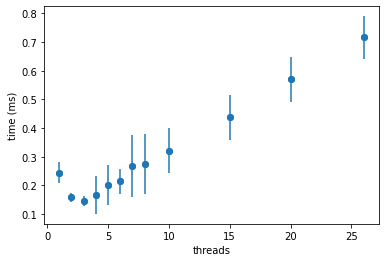

In [118]:
resultMaxParalelo = result
resultMaxParalelo = resultMaxParalelo.loc[resultMaxParalelo['algorithm'] == 'maximoParalelo']
time = resultMaxParalelo['time']['mean'].values.tolist()
std = resultMaxParalelo['time']['std'].values.tolist()
cantThreads = resultMaxParalelo['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

### Multithreading en cargar multiples archivos

In [70]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []
datasetsDir="./data/incremental/"

for repeat in tqdm(range(20)):
    for dataset in os.listdir(datasetsDir):
        #create output file
        result = './results/uniformeMultiplesArchivos.csv'
        outputFile = open(result, 'w+')
        outputFile.write("cantThreads,sec,ns,algorithm\n")

        args = ""
        for file in os.listdir(datasetsDir):
            args += " " + datasetsDir + file

        #print (args)
        for cantThreads in threads:
            command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
            p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
            p.wait()

            output=p.stdout.read().decode("utf-8")
            outputFile.write(output)

        outputFile.close()

        df = pd.read_csv(result, header=[0])
        dataframes.append(df)
    
dfExp2 = pd.concat(dataframes)
print(dfExp2)

100%|██████████| 10/10 [01:01<00:00,  6.13s/it]

    cantThreads  sec        ns                algorithm
0             1    0  20434152  cargarMultiplesArchivos
1             1    0    187774           maximoParalelo
2             2    0   9112952  cargarMultiplesArchivos
3             2    0    132043           maximoParalelo
4             3    0   9271430  cargarMultiplesArchivos
..          ...  ...       ...                      ...
19           15    0    361041           maximoParalelo
20           20    0   8667107  cargarMultiplesArchivos
21           20    0    522608           maximoParalelo
22           26    0   7503027  cargarMultiplesArchivos
23           26    0    662136           maximoParalelo

[7200 rows x 4 columns]


In [71]:
dfExp2['time'] = dfExp2.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExp2 = dfExp2.drop(['sec', 'ns'], axis = 1)
result2 = dfExp2.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(result2)

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  16.833824  1.658195
1            1           maximoParalelo   0.240057  0.049570
2            2  cargarMultiplesArchivos   8.695517  0.964390
3            2           maximoParalelo   0.125352  0.037961
4            3  cargarMultiplesArchivos   8.992807  1.074367
5            3           maximoParalelo   0.114500  0.013827
6            4  cargarMultiplesArchivos   7.110551  0.963871
7            4           maximoParalelo   0.121321  0.013722
8            5  cargarMultiplesArchivos   7.141904  0.574910
9            5           maximoParalelo   0.152892  0.035357
10           6  cargarMultiplesArchivos   7.194901  0.566958
11           6           maximoParalelo   0.197951  0.128104
12           7  cargarMultiplesArchivos   7.294737  1.070517
13           7           maximoParalelo   0.223102  0.187599
14           8  cargarMu

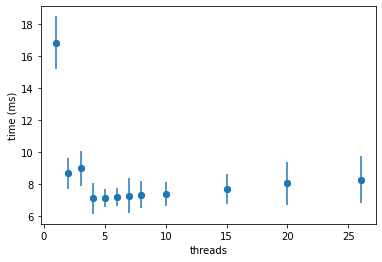

In [72]:
resultMultiArc = result2
resultMultiArc = resultMultiArc.loc[resultMultiArc['algorithm'] == 'cargarMultiplesArchivos']
time = resultMultiArc['time']['mean'].values.tolist()
std = resultMultiArc['time']['std'].values.tolist()
cantThreads = resultMultiArc['cantThreads'].values.tolist()

plt.scatter(cantThreads, time)
plt.errorbar(cantThreads,time, yerr = std, fmt="o")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

### Multithreading de maximo paralelo con distinta distribucion

In [114]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/normal.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/normal.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExpNorm = pd.concat(dataframes)
dfExpNorm['time'] = dfExpNorm.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExpNorm = dfExpNorm.drop(['sec', 'ns'], axis = 1)
resultNorm = dfExpNorm.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(resultNorm)

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  34.051268  2.688087
1            1           maximoParalelo   0.250940  0.043086
2            2  cargarMultiplesArchivos  34.090511  2.437342
3            2           maximoParalelo   0.180105  0.042979
4            3  cargarMultiplesArchivos  33.132230  2.194088
5            3           maximoParalelo   0.150428  0.020050
6            4  cargarMultiplesArchivos  32.641463  2.008951
7            4           maximoParalelo   0.170410  0.032650
8            5  cargarMultiplesArchivos  32.578325  1.767811
9            5           maximoParalelo   0.218507  0.048323
10           6  cargarMultiplesArchivos  32.734801  2.333466
11           6           maximoParalelo   0.231495  0.044125
12           7  cargarMultiplesArchivos  32.561327  1.959231
13           7           maximoParalelo   0.239053  0.038307
14           8  cargarMu

In [112]:
threads = [1,2,3,4,5,6,7,8,10,15,20,26]
columns = ['cantThreads', 'sec', 'ns', 'algorithm']

df = pd.DataFrame(columns = columns)
dataframes = []

for repeat in range(20):
    #create output file
    result = './results/bernoulli.csv'
    outputFile = open(result, 'w+')
    outputFile.write("cantThreads,sec,ns,algorithm\n")
    
    args = "./data/bernoulli.txt"
    
    for cantThreads in threads:
        command = executablePath + " %s %s %s" % (cantThreads, cantThreads, args)
        p = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        p.wait()
        
        output=p.stdout.read().decode("utf-8")
        outputFile.write(output)
    
    outputFile.close()
    
    df = pd.read_csv(result, header=[0])
    dataframes.append(df)
    
dfExpBer = pd.concat(dataframes)
dfExpBer['time'] = dfExpBer.apply(lambda row : getTime(row['sec'],row['ns']), axis = 1)
dfExpBer = dfExpBer.drop(['sec', 'ns'], axis = 1)
resultBer = dfExpBer.groupby(['cantThreads', 'algorithm']).agg({'time':['mean','std']}).reset_index()
print(resultBer)

   cantThreads                algorithm       time          
                                              mean       std
0            1  cargarMultiplesArchivos  41.837045  1.894980
1            1           maximoParalelo   0.274395  0.048266
2            2  cargarMultiplesArchivos  42.100763  3.078073
3            2           maximoParalelo   0.159392  0.027240
4            3  cargarMultiplesArchivos  42.377549  4.678217
5            3           maximoParalelo   0.160451  0.015868
6            4  cargarMultiplesArchivos  41.735775  2.530445
7            4           maximoParalelo   0.184201  0.038879
8            5  cargarMultiplesArchivos  41.141984  2.008087
9            5           maximoParalelo   0.230349  0.073864
10           6  cargarMultiplesArchivos  41.094835  1.657565
11           6           maximoParalelo   0.328872  0.306288
12           7  cargarMultiplesArchivos  41.428439  1.843421
13           7           maximoParalelo   0.233868  0.033695
14           8  cargarMu

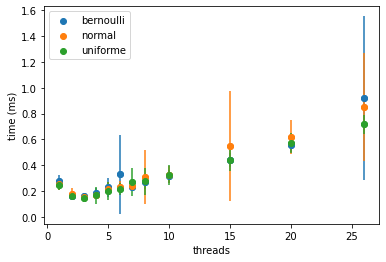

In [119]:
resultMaxParaleloBer = resultBer
resultMaxParaleloBer = resultMaxParaleloBer.loc[resultMaxParaleloBer['algorithm'] == 'maximoParalelo']
timeBer = resultMaxParaleloBer['time']['mean'].values.tolist()
stdBer = resultMaxParaleloBer['time']['std'].values.tolist()
cantThreadsBer = resultMaxParaleloBer['cantThreads'].values.tolist()

resultMaxParaleloNormal = resultNorm
resultMaxParaleloNormal = resultMaxParaleloNormal.loc[resultMaxParaleloNormal['algorithm'] == 'maximoParalelo']
timeNorm = resultMaxParaleloNormal['time']['mean'].values.tolist()
stdNorm = resultMaxParaleloNormal['time']['std'].values.tolist()
cantThreadsNorm = resultMaxParaleloNormal['cantThreads'].values.tolist()

plt.scatter(cantThreadsBer, timeBer, label = "bernoulli")
plt.errorbar(cantThreadsBer,timeBer, yerr = stdBer, fmt="o")

plt.scatter(cantThreadsNorm, timeNorm, label = "normal")
plt.errorbar(cantThreadsNorm,timeNorm, yerr = stdNorm, fmt="o")

plt.scatter(cantThreads, time, label = "uniforme")
plt.errorbar(cantThreads,time, yerr = std, fmt="o")

plt.legend(loc = "upper left")
plt.xlabel('threads')
plt.ylabel('time (ms)')
plt.show()

In [90]:
print(cantThreads)

26
